<div align="center">

  <a href="https://ultralytics.com/yolov5" target="_blank">
    <img width="1024", src="https://github.com/ultralytics/assets/raw/master/yolov5/v62/splash_notebook.png"></a>


<br>
  <a href="https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<br>

This <a href="https://github.com/ultralytics/yolov5">YOLOv5</a> 🚀 notebook by ROAR Lab presents simple train, validate and predict examples to help start your AI adventure.<br>Credit of this notebook goes to <a href="https://ultralytics.com/">Ultralytics</a> and <a href="https://roboflow.com/">Roboflow</a> as this notebook used both sample as reference.

</div>

## Things to Edit ##
- To change the background of the YOLOv5 logo as well as the link buttons to STEAMxD
- I need to include steps 

# First time setup

Use this section to setup your GDrive for YOLOv5 usage with google colab for the first time. **Once this initial setup is done for further usage you will not be required to download the YOLOv5 repository again. Please use the next section [here](#future-setup) when accessing this colab notebook for future usage.**

In this section we're mounting GDrive, cloning GitHub [repository](https://github.com/ultralytics/yolov5), installing [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt), importing necessary libraries and checking PyTorch and GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive
!mkdir steamxd
%cd steamxd

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
from IPython.display import Image, clear_output  # to display images
display = utils.notebook_init()  # checks

# Future usage setup <a id="future-setup"></a>

If you already have YOLOv5 setup in your GDrive use this section to setup your colab notebook.

In this section we're mounting GDrive, installing [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt), importing necessary libraries and checking PyTorch and GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
%cd /mydrive/steamxd/yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
from IPython.display import Image, clear_output  # to display images
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.2-56-g30e674b Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 37.4/166.8 GB disk)


# 1. Image Augmentation <a id="image-aug"></a>

In this example we will do a single augmentation (mosaic) and train the model for a single epoch to showcase the available augmentations while training.

<!---
To edit the instructions to include Augmentation discussions for ease of understanding


`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          path/  # directory
                          'path/*.jpg'  # glob
                          'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                          'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```
-->

In [30]:
import ipywidgets as widgets
import numpy as np
import subprocess
import platform
import math
import random
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [21]:
augmentation_list = ["HSV", "Rotation", "Translate", "Scale", "Shear", "Flip", "Mosaic", "Mixup"]
# remember to change to / for google colab I'm currently testing on windows
img = cv2.imread(r".\data\images\human1.jpg")
img2 = cv2.imread(r".\data\images\lights1.jpg")
img3 = cv2.imread(r".\data\images\phone1.jpg")
img4 = cv2.imread(r".\data\images\cat1.jpg")

file = open(r".\data\images\human1.jpg", "rb")
default_img = file.read()

In [38]:
##################################
### functions for augmentation ###
##################################

def show_image(img):
    # convert from BGR to RGB as cv2 uses BGR color space and plt uses RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img);

def hsv_image(hue, saturation, value):
    hue_ori, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype
    x = np.arange(0, 256, dtype=dtype)
    lut_hue = ((x * hue) % 180).astype(dtype)
    lut_sat = np.clip(x * saturation, 0, 255).astype(dtype)
    lut_val = np.clip(x * value, 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue_ori, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
    img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

    show_image(img_hsv)
    
def rotation_image(rotation_rate):
    # PIL .size(width, height), cv2 .shape(height, width, channel)
    h, w, _ = img.shape
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), rotation_rate, 1)
    img_rot = cv2.warpAffine(img, M, (w, h), borderValue=(114, 114, 114))
    show_image(img_rot)
    
def translate_image(translate_rate):
    h, w, _ = img.shape
    T = np.eye(3)
    T[0, 2] = translate_rate * w
    T[1, 2] = translate_rate * h
    img_translate = cv2.warpAffine(src=img, M=T[:2], dsize=(w, h), borderValue=(114, 114, 114))
    show_image(img_translate)
    
def scale_image(scale_rate):
    h, w, _ = img.shape
    center = (w/2, h/2)
    scale = 1 + scale_rate
    scale_matrix = cv2.getRotationMatrix2D(angle=0, center=center, scale=scale)
    img_scale = cv2.warpAffine(src=img, M=scale_matrix, dsize=(w, h), borderValue=(114, 114, 114))
    show_image(img_scale)
    
def shear_image(shear_rate):
    h, w, _ = img.shape
    S = np.eye(3)
    S[0, 1] = math.tan(shear_rate * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(shear_rate * math.pi / 180)  # y shear (deg)
    img_shear = cv2.warpAffine(src=img, M=S[:2], dsize=(w, h), borderValue=(114, 114, 114))
    show_image(img_shear)
    
def flip_image(flip):
    if flip == "up/down":
        flip_value = 0
    elif flip == "left/right":
        flip_value = 1
    img_flipud = cv2.flip(img, flip_value)
    show_image(img_flipud)
    
def random_rotation(img):
    angle = [45, 90, -45, -90, 0, 180]
    rotation_rate = random.choice(angle)
    h, w, _ = img.shape
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), rotation_rate, 1)
    img_rot = cv2.warpAffine(img, M, (w, h), borderValue=(114, 114, 114))
    return img_rot
    
def mosaic_image(scale):
    scale_range = (scale, 1-scale)
    h, w, _ = img.shape
    img_mosaic = np.zeros([h, w, 3], dtype=np.uint8)
    scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    divid_point_x = int(scale_x * w)
    divid_point_y = int(scale_y * h)

    # top-left
    img_1 = cv2.resize(img, (divid_point_x, divid_point_y))
    img_1 = random_rotation(img_1)
    img_mosaic[:divid_point_y, :divid_point_x, :] = img_1

    # top-right
    img_2 = cv2.resize(img2, (w - divid_point_x, divid_point_y))
    img_2 = random_rotation(img_2)
    img_mosaic[:divid_point_y, divid_point_x:w, :] = img_2

    # btm-left
    img_3 = cv2.resize(img3, (divid_point_x, h - divid_point_y))
    img_3 = random_rotation(img_3)
    img_mosaic[divid_point_y:h, :divid_point_x, :] = img_3

    # btm-right
    img_4 = cv2.resize(img4, (w - divid_point_x, h - divid_point_y))
    img_4 = random_rotation(img_4)
    img_mosaic[divid_point_y:h, divid_point_x:w, :] = img_4

    show_image(img_mosaic)
    
def mixup_image(alpha):
    new_resize = (256, 256)
    img_1 = cv2.resize(img, new_resize, interpolation=cv2.INTER_AREA)
    img_2 = cv2.resize(img2, new_resize, interpolation=cv2.INTER_AREA)
    beta = (1.0 - alpha)
    img_mixup = cv2.addWeighted(img_1, alpha, img_2, beta, 0.0)
    show_image(img_mixup)

In [36]:
########################################
### function for augmentation widget ###
########################################

def augmentation_widget(augmentation):
    if augmentation == "HSV":
        hue_slider = widgets.FloatSlider(min=0, max=1, step=0.1, value=1)
        value_slider = widgets.FloatSlider(min=0, max=1, step=0.1, value=1)
        saturation_slider = widgets.FloatSlider(min=0, max=1, step=0.1, value=1)
        widgets.interact(hsv_image, hue=hue_slider, saturation=saturation_slider, value=value_slider);
                
    elif augmentation == "Rotation":
        rotation_slider = widgets.IntSlider(min=0, max=360, step=10, value=40)
        widgets.interact(rotation_image, rotation_rate=rotation_slider);
        
    elif augmentation == "Translate":
        translate_slider = widgets.FloatSlider(min=-1, max=1, step=0.1, value=0.2)
        widgets.interact(translate_image, translate_rate=translate_slider);
        
    elif augmentation == "Scale":
        scale_slider = widgets.FloatSlider(min=-1, max=1, step=0.1, value=-0.4)
        widgets.interact(scale_image, scale_rate=scale_slider);
    
    elif augmentation == "Shear":
        shear_slider = widgets.IntSlider(min=-20, max=20, step=1, value=5)
        widgets.interact(shear_image, shear_rate=shear_slider);
    
    elif augmentation == "Flip":
        flip_list = ["up/down", "left/right"]
        widgets.interact(flip_image, flip=flip_list);
             
    elif augmentation == "Mosaic":
        mosaic_slider = widgets.FloatSlider(min=0.2, max=0.9, step=0.1, value=0.3)
        widgets.interact(mosaic_image, scale=mosaic_slider);
    
    elif augmentation == "Mixup":
        mixup_slider = widgets.FloatSlider(min=-0.1, max=0.9, step=0.1, value=0.5)
        widgets.interact(mixup_image, alpha=mixup_slider);

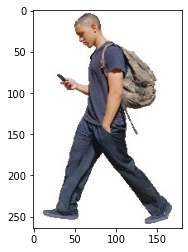

interactive(children=(Dropdown(description='augmentation', options=('HSV', 'Rotation', 'Translate', 'Scale', '…

In [40]:
show_image(img)
widgets.interact(augmentation_widget, augmentation=augmentation_list);

## Image Augmentation Parameters

- To add some simple explanation on the augmentation done

| | Image Augmentation Examples | |
| :-: | :-: | :-: |
| <div><img src="https://user-images.githubusercontent.com/65292018/195560245-3d7a7b5e-13b0-4880-8116-339d50128723.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560259-988483e1-7ae1-476b-85c4-fccc35dd6741.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560275-87b11837-1891-4446-b06b-9ee33bf57357.jpg" width="250"/></div> |
| HSV-Hue    | HSV-Saturation    | HSV-Value |
| <div><img src="https://user-images.githubusercontent.com/65292018/195560226-674913b9-3042-4910-bcce-976ea12393b9.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560269-562f7e81-e6d3-413b-89f8-3d3dcecaf3b5.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560262-7eae030e-0d10-4b81-ab2f-0c18e26303b5.jpg" width="250"/></div> |
| Rotation   | Translation       | Scale     |
| <div><img src="https://user-images.githubusercontent.com/65292018/195560265-3e6d1ecf-142b-4ce4-9024-30f1a0b31159.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560255-8737528e-6c9a-4292-9381-7776a43ae386.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560237-9003d9af-572e-496e-896e-b3a471a6c3cf.jpg" width="250"/></div> |
| Shear      | Perspective       | Flip (up/down) |
| <div><img src="https://user-images.githubusercontent.com/65292018/195560232-12feddfe-c06d-4e0e-ba7c-528a7731ee79.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560251-3a13aa0f-4b95-4a1f-9da8-f6cc69ec812c.jpg" width="250"/></div> | <div><img src="https://user-images.githubusercontent.com/65292018/195560250-c1656e46-9fc9-42f6-a97f-d5368b5650fb.jpg" width="250"/></div> |
| Flip (left/right)   | Mosaic   | Mixup    |

**HSV Augmentation**: HSV (Hue, Saturation, Value) is a colour space developed by A. R. Smith in 1978 based on intuitive colour properties, often known as the Hexcone Model. This model’s colour parameters are hue (H), saturation (S), and lightness (V).

`hsv_h`: HSV-Hue augmentation (fraction; value range 0.0 to 1.0)\
`hsv_s`: HSV-Saturation augmentation (fraction; value range 0.0 to 1.0)\
`hsv_v`: HSV-Value augmentation (fraction; value range 0.0 to 1.0)

**Rotation (degrees) Augmentation**: A random rotation of the image clockwise or counterclockwise by a specified amount of degrees alters the item's location in the frame.

`degrees`: rotation (+/- deg; value range -360.0 to 360.0)

**Translation Augmentation**: Shifts the image along the x- and y-axis independently

`translate`: translation (+/- fraction; value range -1.0 to 1.0)

**Scale Augmentation**: Image is zoomed in or zoomed out

`scale`: scale (+/- gain; value range -1.0 to 1.0)

**Shear Augmentation**: Distort the image along the x- and y-axis to create new perception angles

`shear`: shear (+/- deg; value range -360.0 to 360.0)

**Perspective Augmentation**: Same as shear augmentation

`perspective`: perspective (+/- fraction; value range 0-0.001; recommended to use 0.001)

**Flip Augmentation**: Flip the image vertical (up/down) or horizontally (left/right)

`flipud`: flip up-down (probability; value range 0.0 to 1.0)\
`fliplr`: flip left-right (probability; value range 0.0 to 1.0)

**Mosaic Augmentation**: Combine 4 images into one using a ratio

`mosaic`: mosaic (probability; value range 0.0 to 1.0)

**Mixup Augmentation**: Overlaying of 2 images and their labels

`mixup`: mixup (probability; value range 0.0 to 1.0)

In [1]:
# how to rewrite the hyps yaml
%%writetemplate /mydrive/steamxd/yolov5/data/hyps/hyp.scratch-low.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

#################################
### DO NOT ALTER THIS PORTION ###
#################################
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
#################################
### DO NOT ALTER THIS PORTION ###
#################################
###########################################
### Image Augmentation Parameters Start ###
###########################################
hsv_h: 0.0  # image HSV-Hue augmentation (fraction)
hsv_s: 0.0  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.0  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.0  # image translation (+/- fraction)
scale: 0.0  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.000  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.0  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
#########################################
### Image Augmentation Parameters End ###
#########################################
# copy_paste is for image segmentation leave this augmentation alone
copy_paste: 0.0  # segment copy-paste (probability)

UsageError: Line magic function `%%writetemplate` not found.


## Training Parameters

- Find the explaination from train.py and then include more verbose explaination

`--img`: to specific the input image size 640x640 \
`--batch`: the batch size of the image example input (16 images) [further explaination](https://developers.google.com/machine-learning/glossary#batch) \
`--epochs`: A full training pass over the entire training set such that each example has been processed once. [further explaination](https://developers.google.com/machine-learning/glossary#epoch) \
`--data`: configuration file for where the image dataset is stored \
`--weights`: pre-trained weights \
`--cache`: \
`--name`: this is the folder name for different training runs (e.g. aug-mosaic, aug-mixup, etc) \
`--project`: this is the directory path that you want to save your model runs in (e.g. '/mydrive/SUTD/STEAMxD') \
`--resume`: this will resume training of your model if training is interrupted (e.g. epochs 100, training stops at epochs 55.) If all epochs has been done (100/100) but you still wish to continue training on the existing model use the `--weights` flag instead (e.g. --weights /mydrive/SUTD/STEAMxD/yolov5/runs/train/exp) 

<!---
--project can be removed if I'm gonna just be cloning the yolov5 repo into gdrive
--resume flag to resume training if you're initial training epochs (300 and your model stops as 150)
--weights alternatively you can use the --weights flag to specific the weights file to continue training from
--data I need to add in the yaml file edit so that I can link it to the correct dataset
I should add in and image to explain the epochs and batch size
-->

In [ ]:
# give some explanation of the different parameters
!python train.py --img 640 --batch 16 --epochs 1 --data coco128.yaml --weights yolov5s.pt --cache --name aug-mosaic --project '/mydrive/SUTD/STEAMxD'

## Tensorboard

- to insert description

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
# if you see a google 403 error please ensure that your browser allows 3rd party cookie for tensorboard to be viewable
%load_ext tensorboard
%tensorboard --logdir runs/train

## Visualising augmented images during training

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/aug-mosaic2/train_batch1.jpg', width=900)

# 2. Training custom model

Using the augmentation parameters that you've experimented in the [previous section](#image-aug), we will be training the custom model using your custom dataset.

<!---
To edit the instructions to include Augmentation discussions for ease of understanding


`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          path/  # directory
                          'path/*.jpg'  # glob
                          'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                          'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```
-->

In [1]:
# how to rewrite the hyps yaml
%%writetemplate /mydrive/steamxd/yolov5/data/hyps/hyp.scratch-low.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

#################################
### DO NOT ALTER THIS PORTION ###
#################################
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
#################################
### DO NOT ALTER THIS PORTION ###
#################################
###########################################
### Image Augmentation Parameters Start ###
###########################################
hsv_h: 0.0  # image HSV-Hue augmentation (fraction)
hsv_s: 0.0  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.0  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.0  # image translation (+/- fraction)
scale: 0.0  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.000  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.0  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
#########################################
### Image Augmentation Parameters End ###
#########################################
# copy_paste is for image segmentation leave this augmentation alone
copy_paste: 0.0  # segment copy-paste (probability)

UsageError: Line magic function `%%writetemplate` not found.


## Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# COCO128 dataset https://www.kaggle.com/ultralytics/coco128 (first 128 images from COCO train2017) by Ultralytics
# Example usage: python train.py --data coco128.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco128  ← downloads here (7 MB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco128  # dataset root dir
train: images/train2017  # train images (relative to 'path') 128 images
val: images/train2017  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush


# Download script/URL (optional)
download: https://ultralytics.com/assets/coco128.zip


In [ ]:
#this is the model configuration we will use for our training
%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Training Parameters

- Find the explaination from train.py and then include more verbose explaination

`--img`: \
`--batch`: \
`--epochs`: \
`--data`: \
`--weights`: \
`--cache`: \
`--name`: \
`--project`: this is the directory path that you want to save your model runs in (e.g. '/mydrive/SUTD/STEAMxD')\
`--resume`: this will resume training of your model if training is interrupted

<!---
--project can be removed if I'm gonna just be cloning the yolov5 repo into gdrive
--resume flag to resume training if you're initial training epochs (300 and your model stops as 150)
--weights alternatively you can use the --weights flag to specific the weights file to continue training from
--data I need to add in the yaml file edit so that I can link it to the correct dataset
-->

In [ ]:
# give some explanation of the different parameters
!python train.py --img 640 --batch 16 --epochs 1 --data coco128.yaml --weights yolov5s.pt --cache --name aug-mosaic --project '/mydrive/SUTD/STEAMxD'

## Tensorboard

- to insert description

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
# if you see a google 403 error please ensure that your browser allows 3rd party cookie for tensorboard to be viewable
%load_ext tensorboard
%tensorboard --logdir runs/train

## Visualising augmented images during training

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/aug-mosaic2/train_batch1.jpg', width=900)